KeyboardInterrupt: 

Running comprehensive analysis for all scenarios...
Testing 1-choice...
Testing 2-choice...
Testing (1+0.3)-choice...
Testing (1+0.5)-choice...
Testing (1+0.7)-choice...
Testing Partial info (k=2)...
Testing Batched 2-Ch (b=2m)...
Testing Batched 2-Ch (b=10m)...


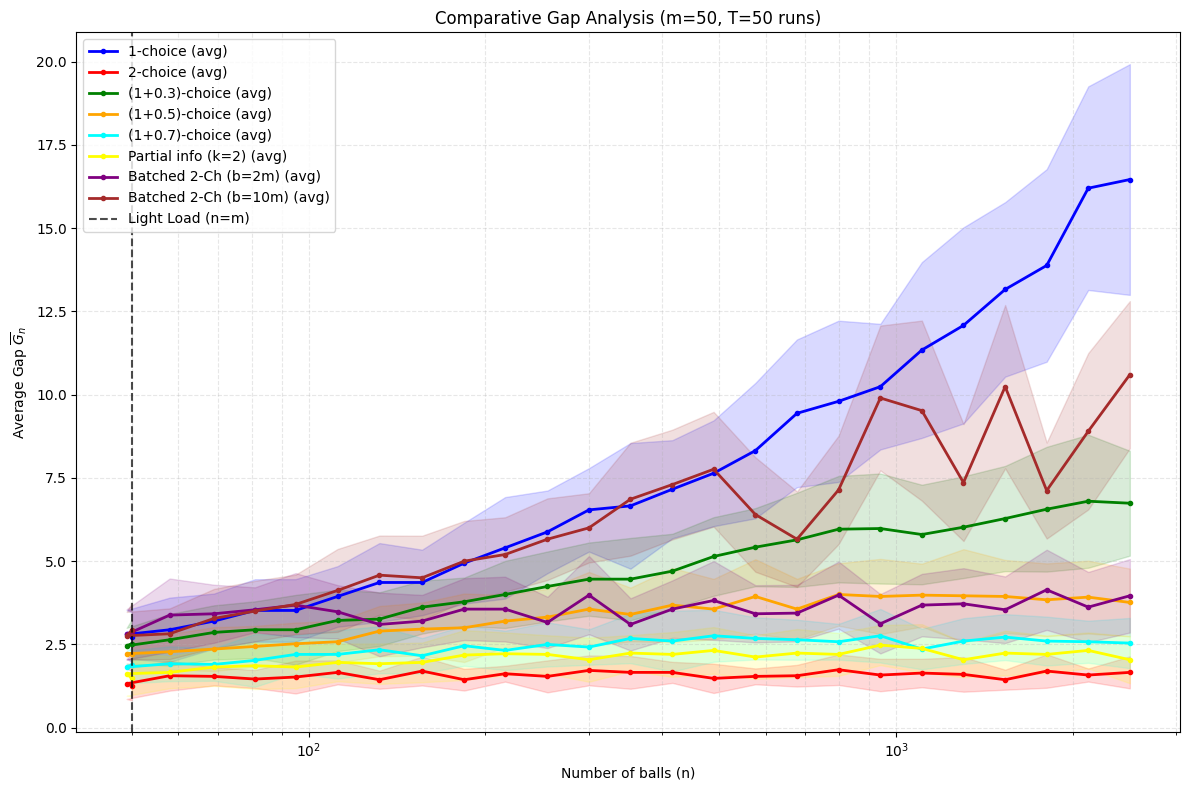

Analysis complete!


In [ ]:

import matplotlib.pyplot as plt
import random
import numpy as np
from typing import List, Dict, Tuple

class BinAllocationExperiment:
    """Manages the state of the bins and implements the core allocation strategies."""
    def __init__(self, m: int):
        self.m = m
        self.bins = [0] * m
        
    def reset(self):
        """Reset the bins to zero load for a new trial."""
        self.bins = [0] * self.m
        
    def allocate_one_choice(self, snapshot_bins=None) -> int:
        """Standard one-choice allocation."""
        if snapshot_bins is None:
            snapshot_bins = self.bins
        return random.randint(0, self.m - 1)
        
    def allocate_d_choice(self, d: int, snapshot_bins=None) -> int:
        """d-choice allocation: choose the least loaded among d random bins."""
        if snapshot_bins is None:
            snapshot_bins = self.bins
            
        candidates = random.sample(range(self.m), d)
        min_load = min(snapshot_bins[c] for c in candidates)
        best_candidates = [c for c in candidates if snapshot_bins[c] == min_load]
        return random.choice(best_candidates)
        
    def allocate_one_plus_beta(self, beta: float, snapshot_bins=None) -> int:
        """(1+β)-choice allocation (β is P(two-choice))."""
        if random.random() < beta:  # Use two-choice with probability β
            return self.allocate_d_choice(2, snapshot_bins)
        else:  # Use one-choice with probability 1-β
            return self.allocate_one_choice(snapshot_bins)
            
    def allocate_with_partial_info(self, d: int, k: int, snapshot_bins=None) -> int:
        """Allocation with partial information using k questions (d=2 assumed)."""
        if snapshot_bins is None:
            snapshot_bins = self.bins
            
        candidates = random.sample(range(self.m), d)
        
        # Calculate thresholds
        median = np.median(snapshot_bins)
        Q1_load = np.percentile(snapshot_bins, 25)
        Q3_load = np.percentile(snapshot_bins, 75)
        
        above_median = [c for c in candidates if snapshot_bins[c] > median]
        below_median = [c for c in candidates if snapshot_bins[c] <= median]

        # --- Q1: Is load > median? ---
        if above_median and below_median:
            # Q1 Resolution (Answers differ): Choose the one NOT above the median
            return below_median[0]
            
        # --- Q2 Logic (If answers were equal for Q1) ---
        
        # All below/equal median
        elif below_median:
            if k == 1:
                return random.choice(candidates) # Tie-break with k=1
            
            # Q2a: Ask if among the 75% most loaded? (load >= Q1_load)
            in_top_75 = [c for c in below_median if snapshot_bins[c] >= Q1_load]
            not_in_top_75 = [c for c in below_median if snapshot_bins[c] < Q1_load]
            
            if in_top_75 and not_in_top_75:
                # Q2 Resolution (Answers differ): Choose the one NOT in top 75% (the less loaded)
                return not_in_top_75[0]
            else:
                # Q2 Tie-break: Pick one at random
                return random.choice(below_median)
                
        # All above median  
        else:
            if k == 1:
                return random.choice(candidates) # Tie-break with k=1

            # Q2b: Ask if among the 25% most loaded? (load >= Q3_load)
            in_top_25 = [c for c in above_median if snapshot_bins[c] >= Q3_load]
            not_in_top_25 = [c for c in above_median if snapshot_bins[c] < Q3_load]

            if in_top_25 and not_in_top_25:
                # Q2 Resolution (Answers differ): Choose the one NOT in top 25% (the less loaded)
                return not_in_top_25[0]
            else:
                # Q2 Tie-break: Pick one at random
                return random.choice(above_median)
        
        return random.choice(candidates) # Fallback

    def calculate_gap(self, n: int) -> float:
        """Calculate the gap Gn = max(Xi) - n/m."""
        return max(self.bins) - (n / self.m)
        
    def run_allocation(self, n: int, strategy: str, **kwargs) -> float:
        """Runs allocation of n balls using specified strategy, handling batching."""
        self.reset()
        
        d = kwargs.get('d', 1)
        beta = kwargs.get('beta', None)
        k = kwargs.get('k', 0)
        batch_size = kwargs.get('batch_size', 1)
        
        balls_allocated = 0
        
        while balls_allocated < n:
            # For batching: snapshot is taken at the start of each batch
            current_batch_size = min(batch_size, n - balls_allocated)
            snapshot = self.bins.copy() if batch_size > 1 or strategy == "partial_info" else None
            
            for _ in range(current_batch_size):
                if balls_allocated >= n:
                    break
                    
                if strategy == "one_choice":
                    bin_idx = self.allocate_one_choice(snapshot)
                elif strategy == "d_choice":
                    bin_idx = self.allocate_d_choice(d, snapshot)
                elif strategy == "one_plus_beta":
                    bin_idx = self.allocate_one_plus_beta(beta, snapshot)
                elif strategy == "partial_info":
                    bin_idx = self.allocate_with_partial_info(d, k, snapshot)
                else:
                    raise ValueError(f"Unknown strategy: {strategy}")
                    
                self.bins[bin_idx] += 1
                balls_allocated += 1
                
        return self.calculate_gap(n)

def run_experiments(m: int, n_values: List[int], strategy: str, T: int = 10, **kwargs) -> Dict:
    """Run experiments for multiple n values and return statistics."""
    results = {
        'n_values': n_values,
        'avg_gaps': [],
        'std_gaps': [],
        'all_gaps': []
    }
    
    experiment = BinAllocationExperiment(m)
    
    for n in n_values:
        gaps = []
        for t in range(T):
            gap = experiment.run_allocation(n, strategy, **kwargs)
            gaps.append(gap)
            
        results['avg_gaps'].append(np.mean(gaps))
        results['std_gaps'].append(np.std(gaps))
        results['all_gaps'].append(gaps)
        
    return results

def plot_results(results_dict: Dict, title: str, m: int):
    """Plot the results of experiments."""
    plt.figure(figsize=(12, 8))
    
    colors = ['blue', 'red', 'green', 'orange', 'cyan', 'yellow','purple', 'brown', 'pink', 'gray']
    color_idx = 0
    
    for strategy_name, results in results_dict.items():
        n_values = results['n_values']
        avg_gaps = results['avg_gaps']
        std_gaps = results['std_gaps']
        
        color = colors[color_idx % len(colors)]
        color_idx += 1
        
        # Plot average gap (required)
        plt.plot(n_values, avg_gaps, label=f'{strategy_name} (avg)', 
                 color=color, linewidth=2, marker='.')
        
        # Plot error bars for standard deviation (required)
        plt.fill_between(n_values, 
                         [avg - std for avg, std in zip(avg_gaps, std_gaps)],
                         [avg + std for avg, std in zip(avg_gaps, std_gaps)],
                         alpha=0.15, color=color)
    
    # Highlight light-load scenario (n = m) (required)
    light_load_n = m
    plt.axvline(x=light_load_n, color='black', linestyle='--', alpha=0.7, label='Light Load (n=m)')
    
    plt.xlabel('Number of balls (n)')
    plt.ylabel('Average Gap $\\overline{G}_n$')
    plt.title(title)
    plt.legend(loc='upper left')
    plt.grid(True, which='both', linestyle='--', alpha=0.3)
    plt.xscale('log') # Use log scale for clarity from m to m^2
    plt.tight_layout()
    plt.show()

# For Jupyter: Run the analysis directly
def run_analysis():
    m = 50  # Number of bins
    T = 50  # Number of rounds
    
    print("Running comprehensive analysis for all scenarios...")
    
    # Define n values from light load (m) to heavy load (m^2)
    n_values = np.unique(np.logspace(np.log10(m), np.log10(m*m), 25, dtype=int))
    if n_values[0] != m: 
        n_values = np.insert(n_values, 0, m)
        
    results_dict = {}
    
    strategies_to_test = [
        ("1-choice", "one_choice", {}),
        ("2-choice", "d_choice", {"d": 2}),
        ("(1+0.3)-choice", "one_plus_beta", {"beta": 0.3}),
        ("(1+0.5)-choice", "one_plus_beta", {"beta": 0.5}),
        ("(1+0.7)-choice", "one_plus_beta", {"beta": 0.7}),

        ("Partial info (k=2)", "partial_info", {"d": 2, "k": 2}),
    ]
    
    # Scenario 2: Batch analysis (using 2-choice logic)
    batch_sizes = [2*m, 10*m, 70*m] 
    for b_size in batch_sizes:
        if b_size <= m*m:
            strategies_to_test.append((f"Batched 2-Ch (b={b_size/m:.0f}m)", "d_choice", {"d": 2, "batch_size": b_size}))
    
    for strategy_name, strategy, params in strategies_to_test:
        print(f"Testing {strategy_name}...")
        results = run_experiments(m, n_values, strategy, T, **params)
        results_dict[strategy_name] = results
        
    plot_results(results_dict, f"Comparative Gap Analysis (m={m}, T={T} runs)", m)
    print("Analysis complete!")

# Run in Jupyter
run_analysis()

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def run_experiment(num_bins, num_balls, strategy, extra_params=None):
    bins = [0] * num_bins
    
    if extra_params is None:
        extra_params = {}
    
    beta = extra_params.get('beta', 0.5)
    k = extra_params.get('k', 0)
    batch_size = extra_params.get('batch_size', 1)
    
    balls_used = 0
    
    while balls_used < num_balls:
        this_batch = min(batch_size, num_balls - balls_used)
        if batch_size > 1 or strategy == "partial_info":
            bin_snapshot = bins.copy()
        else:
            bin_snapshot = bins        
        for i in range(this_batch):
            chosen_bin = -1
            
            
            if strategy == "one_choice":
                # Pick a random bin
                chosen_bin = random.randint(0, num_bins - 1)
                
            elif strategy == "d_choice":
                # Pick d random bins and choose the emptiest one
                random_bins = random.sample(range(num_bins), 2)
                
                min_balls = bin_snapshot[random_bins[0]]
                best_bins = [random_bins[0]]
                
                for bin_idx in random_bins[1:]:
                    if bin_snapshot[bin_idx] < min_balls:
                        min_balls = bin_snapshot[bin_idx]
                        best_bins = [bin_idx]
                    elif bin_snapshot[bin_idx] == min_balls:
                        best_bins.append(bin_idx)
                
                chosen_bin = random.choice(best_bins)
                
            elif strategy == "one_plus_beta":
                if random.random() < beta:
                    random_bins = random.sample(range(num_bins), 2)
                    
                    if bin_snapshot[random_bins[0]] < bin_snapshot[random_bins[1]]:
                        chosen_bin = random_bins[0]
                    elif bin_snapshot[random_bins[1]] < bin_snapshot[random_bins[0]]:
                        chosen_bin = random_bins[1]
                    else:
                        chosen_bin = random.choice(random_bins)
                else:
                    chosen_bin = random.randint(0, num_bins - 1)
                    
            elif strategy == "partial_info":
                random_bins = random.sample(range(num_bins), 2)
                Q3_load = np.percentile(bin_snapshot, 75)
                median = np.median(bin_snapshot)
                Q1_load = np.percentile(bin_snapshot, 25) 
                above_median = [c for c in random_bins if bin_snapshot[c] > median]
                below_median = [c for c in random_bins if bin_snapshot[c] <= median]

                if above_median and below_median:
                    chosen_bin = below_median[0]
                                    
                elif below_median:
                    if k == 1:
                        chosen_bin = random.choice(random_bins)
                    else:
                        in_top_75 = [c for c in below_median if bin_snapshot[c] >= Q1_load]
                        not_in_top_75 = [c for c in below_median if bin_snapshot[c] < Q1_load]
                        
                        if in_top_75 and not_in_top_75:
                            chosen_bin = not_in_top_75[0]
                        else:
                            chosen_bin = random.choice(below_median)
                            
                else:
                    if k == 1:
                        chosen_bin = random.choice(random_bins)
                    else:
                        in_top_25 = [c for c in above_median if bin_snapshot[c] >= Q3_load]
                        not_in_top_25 = [c for c in above_median if bin_snapshot[c] < Q3_load]

                        if in_top_25 and not_in_top_25:
                            chosen_bin = not_in_top_25[0]
                        else:
                            chosen_bin = random.choice(above_median)
                            
            else:
                # Unknown strategy, just pick random
                chosen_bin = random.randint(0, num_bins - 1)
            
            bins[chosen_bin] += 1
            balls_used += 1
    
    # Calculate the gap: max load - average load
    max_load = max(bins)
    avg_load = num_balls / num_bins
    gap = max_load - avg_load
    
    return gap



#Mutliple trials
def run_multiple_trials(num_bins, num_balls_list, strategy, num_trials=10, extra_params=None):
    avg_gaps = []
    std_gaps = []
    
    for num_balls in num_balls_list:
        #gap is the difference between max load and average load
        gaps = []
        for trial in range(num_trials):
            gap = run_experiment(num_bins, num_balls, strategy, extra_params) 
            gaps.append(gap)
        
        average_gap = sum(gaps) / len(gaps)
        variance = sum((x - average_gap) ** 2 for x in gaps) / len(gaps)
        std_dev = variance ** 0.5
        
        avg_gaps.append(average_gap)
        std_gaps.append(std_dev)
    
    return avg_gaps, std_gaps

#plotting
def make_plot(results, m):
    plt.figure(figsize=(10, 6))
    
    for name, x, y, _ in results:
        plt.plot(x, y, label=name, marker='o')
    
    plt.xlabel('Balls')
    plt.ylabel('Gap')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main 
    
num_bins = 50
num_trials = 20
    
n_values = [50, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500]
all_results = []
    
# One-choice (baseline)
print("Testing 1-choice strategy")
avg_gaps, std_gaps = run_multiple_trials(num_bins, n_values, "one_choice", num_trials)
all_results.append(("1-choice", n_values, avg_gaps, std_gaps))
    
    # Two-choice
print("Testing 2-choice strategy")
avg_gaps, std_gaps = run_multiple_trials(num_bins, n_values, "d_choice", num_trials)
all_results.append(("2-choice", n_values, avg_gaps, std_gaps))
    
        # (1+beta) strategies
for beta in [0.3, 0.5, 0.8] :
    print(f"Testing (1+{beta})-choice strategy")
    avg_gaps, std_gaps = run_multiple_trials(num_bins, n_values, "one_plus_beta", num_trials, {'beta': beta})
    all_results.append((f"(1+{beta})-choice", n_values, avg_gaps, std_gaps))
    
# Partial information
print("Testing partial information (k=2)")
avg_gaps, std_gaps = run_multiple_trials(num_bins, n_values, "partial_info", num_trials)
all_results.append(("Partial info (k=2)", n_values, avg_gaps, std_gaps))
    
    # Batched 2-choice
batch_size = 500
print(f"Testing batched 2-choice (b=10m)")
avg_gaps, std_gaps = run_multiple_trials(num_bins, n_values, "d_choice", num_trials, {'batch_size': batch_size})
all_results.append((f"Batch {batch_size//num_bins}m (2-ch)", n_values, avg_gaps, std_gaps))

make_plot(all_results, num_bins)

Testing 1-choice strategy
Testing 2-choice strategy
Testing (1+0.3)-choice strategy


In [7]:
df_data = {'n': all_results[0][1]}

for strategy, _, gaps, stds in all_results:
    df_data[f"{strategy}_gap"] = gaps
    df_data[f"{strategy}_std"] = stds

df = pd.DataFrame(df_data)
print(df)

       n  1-choice_gap  1-choice_std  2-choice_gap  2-choice_std  \
0     50          2.70      0.714143          1.20      0.400000   
1    250          6.10      1.374773          1.80      0.400000   
2    500          8.05      2.224298          1.65      0.476970   
3    750          9.20      1.630951          1.80      0.400000   
4   1000         10.70      2.325941          1.75      0.433013   
5   1250         12.55      3.513901          1.75      0.433013   
6   1500         12.70      2.758623          1.70      0.458258   
7   1750         13.85      2.308138          1.70      0.458258   
8   2000         14.05      3.138073          1.60      0.489898   
9   2250         15.75      2.586020          1.60      0.489898   
10  2500         15.10      2.681418          1.60      0.489898   

    (1+0.3)-choice_gap  (1+0.3)-choice_std  (1+0.5)-choice_gap  \
0                 2.35            0.653835                2.10   
1                 4.00            0.836660         